#                          Lab #1: AVL TREES

                                            Universidad del Norte
                                Computer and Systems Engineering Department
                                            Data structures II

Juan Andrés Povea 200179190
Jeśus David Cantillo 200176862
Yovany Zhu Ye 200177576
Carlos Elías López 200176533 

In [3]:
# Here we import all the necessary libraries and data structures

import pandas as pd
import folium
from __future__ import annotations
from typing import Optional, Tuple, List, Any
from collections import deque
from graphviz import Digraph
from graphviz import Source
from IPython.display import Image, display

# In order to manipulate the data in an easier way, we parse the csv to a list of dicts
data_dict = pd.read_csv('co_properties_final.csv').to_dict(orient='records')
data = pd.read_csv('co_properties_final.csv')
data

,title,department,city,property_type,latitude,longitude,surface_total,surface_covered,bedrooms,bathrooms,operation_type,price
0,Apartamento En Arriendo/venta En Barranquilla ...,Atlántico,Barranquilla,Apartamento,11.013,-74.836,70.0,70.0,1.0,2.0,Venta,2.500000e+08
1,Casa En Venta En Cali Ciudad Jardn Cod. VVLZ3039,Valle del Cauca,Cali,Casa,3.368,-76.531,420.0,420.0,5.0,5.0,Venta,9.500000e+08
2,Casa En Arriendo/venta En Barranquilla Bellavi...,Atlántico,Barranquilla,Casa,10.997,-74.791,83.0,150.0,3.0,3.0,Venta,3.200000e+08
3,Casa En Arriendo En Chia Chia Cod. AINH2992,Cundinamarca,Chía,Casa,4.845,-74.057,580.0,2.0,8.0,3.0,Arriendo,8.000000e+06
4,Apartamento En Arriendo En Cali Ciudad Crdoba ...,Valle del Cauca,Cali,Apartamento,3.402,-76.507,56.0,56.0,3.0,1.0,Arriendo,5.500000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
145,Apartamento En Arriendo En Bucaramanga Ciudade...,Santander,Bucaramanga,Apartamento,7.104,-73.129,85.0,85.0,3.0,3.0,Arriendo,8.500000e+05
146,Casa En Venta En Bogota Lagos De Crdoba Cod. V...,Cundinamarca,Bogotá D.C,Casa,4.708,-74.073,325.0,316.0,4.0,6.0,Venta,1.100000e+09
147,Apartamento En Venta En Bogota Santa Brbara Co...,Cundinamarca,Bogotá D.C,Apartamento,4.694,-74.036,166.0,166.0,4.0,4.0,Venta,9.000000e+08
148,Casa Condominio En Venta En La Calera Vereda S...,Cundinamarca,La Calera,Casa,4.748,-73.952,3800.0,550.0,4.0,6.0,Venta,2.650000e+09


## Classes and methods

---

In [4]:
class Node:

    node_counter = 0
    def __init__(self, data: dict) -> None:
        Node.node_counter+=1
        data['metric'] = data['price'] / data['surface_total']

        data['second_metric'] = Node.node_counter

        data['balance'] = 0
        
        self.data: dict = data
        self.left: Optional["Node"] = None
        self.right: Optional["Node"] = None
        self.height = 1    


    def __repr__(self) -> str:
     return f"""
     Metric: {self.data['metric']}
     Second Metric: {self.data['second_metric']}
     Balance: {self.data['balance']}
     Title: {self.data["title"]}
     Department: {self.data["department"]}
     City: {self.data["city"]}
     Property Type: {self.data["property_type"]}
     Latitude: {self.data["latitude"]}
     Longitude: {self.data["longitude"]}
     Total Area: {self.data["surface_total"]}
     Covered Area: {self.data["surface_covered"]}
     Bedrooms: {self.data["bedrooms"]}
     Bathrooms: {self.data["bathrooms"]}
     Operation Type: {self.data["operation_type"]}
     Price: {self.data["price"]}
     """


In [5]:
# This class parse the queries and checks if a given node matches a certain conditions
class QueryManager:

    def node_matches_query(self, node: "Node", query_conditions: List[str]) -> bool:

        all_conditions_matched = True

        for condition in query_conditions:
            if not eval(condition):
                all_conditions_matched = False
                break            

        return all_conditions_matched 

    def parse_query(self, query: str) -> str:
        components = query.split() 
        select_clause = ' '.join(components[0: components.index('WHERE')])
        if select_clause!= 'SELECT *':
            raise Exception ('The parser couldn\'t find the "SELECT * " statement in the query')
        conditions = ' '.join(components[components.index('WHERE')+1:]).split(' and ')
        return conditions

In [6]:
class AVL:

    qm = QueryManager()

    def __init__(self) -> None:
        self.root: Optional["Node"] = None

    def insert(self, data: dict) -> bool:
        to_insert = Node(data)  
        if self.root is None:
            self.root = to_insert
            return True
        else:
            self.root = self._insert(self.root, to_insert)
            return True

    def _insert(self, node: Optional[Node], to_insert: Node) -> Node:
        if node is None:
            return to_insert

        # In this condition we basically check in which position the current node have to be 
        if to_insert.data['metric'] < node.data['metric']:
            node.left = self._insert(node.left, to_insert)
        else:
            node.right = self._insert(node.right, to_insert)

        # Once we assign the position, we update the node's height
        node.height = 1 + max(self.get_height(node.left), self.get_height(node.right))

        balance = self.get_balance(node)

        # Of course, once we insert the node we need to check the balance factor
        if balance > 1: 
            if to_insert.data['metric'] < node.left.data['metric']:
                return self._rotate_right(node)
            else:
                node.left = self._rotate_left(node.left)
                return self._rotate_right(node)

        if balance < -1:
            if to_insert.data['metric'] > node.right.data['metric']:
                return self._rotate_left(node)
            else:
                node.right = self._rotate_right(node.right)
                return self._rotate_left(node)

        return node

    def delete(self, metric: float) -> bool:
        if self.root is None:
            return False  
        else:
            self.root, _ = self._delete(self.root, metric)
            print("Eliminiao")
            return True

    def _delete(self, node: Node, metric: float) -> Tuple[Optional[Node], bool]:

        # This variable indicates if there's a node in the tree with the given metric
        metric_found = False

        if node is None:
            return node, metric_found    

        if metric < node.data['metric']: # We start to move based on the value of metric and recall _delete
            node.left, metric_found = self._delete(node.left, metric)
        elif metric > node.data['metric']:
            node.right, metric_found = self._delete(node.right, metric)
        else:
        
            if node.left is None:
                return node.right, True
            elif node.right is None:
                return node.left, True
            else:
                
                # find_min returns the successor 
                min_node = self._find_min(node.right)
                node.data = min_node.data  
                node.right, _ = self._delete(node.right, min_node.data['metric'])  


        node.height = 1 + max(self.get_height(node.left), self.get_height(node.right))
        balance = self.get_balance(node)

        if balance > 1:
            if self.get_balance(node.left) >= 0:
                return self._rotate_right(node), metric_found
            else:
                node.left = self._rotate_left(node.left)
                return self._rotate_right(node), metric_found

        if balance < -1:
            if self.get_balance(node.right) <= 0:
                return self._rotate_left(node), metric_found
            else:
                node.right = self._rotate_right(node.right)
                return self._rotate_left(node), metric_found

        return node, metric_found

    def search(self, metric: float) -> Tuple[Optional["Node"], Optional["Node"]]:
        p, pad = self.root, None
        while p is not None:
            if metric == p.data['metric']:
                return p, pad
            else:
                pad = p
                if metric < p.data['metric']:
                    p = p.left
                else:
                    p = p.right
        return p, pad

    def search_grandfather(self, metric: float) -> Optional[Node]:
        # First, we get the father of the node with the given metric
        _, pad = self.search(metric)  

        # Now we apply the search fn to the father of that node 
        # so it will get the father of the father and return it
        _, g_pad = self.search(pad.data['metric'])
        return g_pad


    def _rotate_left(self, z: Node) -> Node:
        y = z.right
        T2 = y.left

        y.left = z
        z.right = T2

        z.height = 1 + max(self.get_height(z.left), self.get_height(z.right))
        y.height = 1 + max(self.get_height(y.left), self.get_height(y.right))

        return y

    def _rotate_right(self, y: Node) -> Node:
        if y is None or y.left is None:
            return y

        x = y.left
        T2 = x.right

        x.right = y
        y.left = T2

        y.height = 1 + max(self.get_height(y.left), self.get_height(y.right))
        x.height = 1 + max(self.get_height(x.left), self.get_height(x.right))

        return x

    # This fn finds the successor of a given node
    def _find_min(self, node: Node) -> Node:
        while node.left is not None:
            node = node.left
        return node

    def search_uncle(self, metric: float) -> "Node"|None:
        _, pad = self.search(metric)
        g_pad = self.search_grandfather(metric)
        if g_pad.left == pad:
            return g_pad.right
        else:
            return g_pad.left

    def get_node_level(self, target_metric: float) -> int:
        if self.root is None:
            return -1  
        queue = deque([(self.root, 0)])  
        while queue:
            current_node, level = queue.popleft() 

            if current_node.data['metric'] == target_metric:
                return level 

            if current_node.left:
                queue.append((current_node.left, level + 1))
            if current_node.right:
                queue.append((current_node.right, level + 1))

        return -1  #


    def show_level_traversal(self):
        current_level = []
        print("{:<15} {:<15} {:<15}".format("Metric", "Second Metric", "Balance"))
        current_level.append(self.root)
        def level_traversal_helper(current_level):
            if not current_level:
                return

    
            next_level = []

            for node in current_level:
                balance_factor = self.get_balance(node)
                ft = "{:<15.2f} {:<15.2f} {:<15}".format(node.data['metric'], node.data['second_metric'], self.get_balance(node))
                print(ft)
                if node.left:
                    next_level.append(node.left)
                if node.right:
                    next_level.append(node.right)

            level_traversal_helper(next_level)

        level_traversal_helper(current_level) 

    def to_dot(self):
        dot = Digraph()
        if self.root is not None:
            queue = deque()
            queue.append(self.root)

            while queue:
                node = queue.popleft()
                label = f"Metric: {node.data['metric']}\nSecond Metric: {node.data['second_metric']}\nBalance: {-1 * self.get_balance(node)}"
                dot.node(str(node.data["second_metric"]), label)  # Usamos el label personalizado
                if node.left:
                    dot.edge(str(node.data["second_metric"]), str(node.left.data["second_metric"]))
                    queue.append(node.left)
                if node.right:
                    dot.edge(str(node.data["second_metric"]), str(node.right.data["second_metric"]))
                    queue.append(node.right)

        return dot


    def get_height(self, node: Optional[Node]) -> int:
        if node is None:
            return 0
        return node.height

    def get_balance(self, node: Optional[Node]) -> int:
        if node is None:
            return 0
        return self.get_height(node.left) - self.get_height(node.right)

    def execute_query(self, query: str) -> List["Node"]:
        query_conditions = AVL.qm.parse_query(query)

        return self.__check_nodes_by_levels(query_conditions)    

    def __pred(self, node: "Node") -> Tuple["Node", "Node"]:
        p, pad = node.left, node
        while p.right is not None:
            p, pad = p.right, p

        return p, pad


    def __sus(self, node: "Node") -> Tuple["Node", "Node"]:
        p, pad = node.right, node
        while p.left is not None:
            p, pad = p.left, p

        return p, pad    

    def __check_nodes_by_levels(self, query_conditions: List[str]) -> List["Node"]:
        matching_nodes = []  

        def check_nodes_by_level_helper(current_level, matching_nodes, query_conditions: List[str]):
            if not current_level:
                return

            next_level = []
            for node in current_level:

                conditions_matched = AVL.qm.node_matches_query(node, query_conditions)

                if conditions_matched:
                    matching_nodes.append(node)
                if node.left:
                    next_level.append(node.left)
                if node.right:
                    next_level.append(node.right)

            check_nodes_by_level_helper(next_level, matching_nodes, query_conditions)

        current_level = []

        if self.root is None:
            return matching_nodes
        current_level.append(self.root)

        check_nodes_by_level_helper(current_level, matching_nodes, query_conditions)

        return matching_nodes      

## Tree creation and level traversal

In [7]:
avl_tree = AVL()

for record in data_dict:
    avl_tree.insert(record)

avl_tree.show_level_traversal()

Metric          Second Metric   Balance        
1187371.31      10.00           0              
18853.70        12.00           0              
3571428.57      1.00            0              
13793.10        4.00            0              
31428.57        7.00            0              
2368421.05      36.00           1              
4753519.74      88.00           0              
10285.71        60.00           0              
15625.00        20.00           -1             
24390.24        59.00           0              
45370.86        11.00           -1             
2155172.41      15.00           1              
2890625.00      69.00           0              
3865979.38      6.00            0              
6388888.89      55.00           0              
8163.27         14.00           0              
12359.55        99.00           -1             
14545.45        57.00           0              
17142.86        89.00           0              
19767.44        39.00           0       

## Node operations

---

### Operations with nodes using search criteria and metrics

**Enter the criteria for the search of the nodes, using SQL syntax**
**For example:   node.data['second_metric']== 82**

---

Select the operation:

In [15]:
operation = 'Find all nodes'

In [16]:
node_query = ' node.data[\'city\']== \'Barranquilla\' and node.data[\'bedrooms\']>2 and node.data[\'price\']<=15000000'

[
     Metric: 17142.85714285714
     Second Metric: 89
     Balance: 0
     Title: Apartamento En Arriendo En Barranquilla Colombia Cod. AADN758870
     Department: Atlántico
     City: Barranquilla
     Property Type: Apartamento
     Latitude: 10.992
     Longitude: -74.804
     Total Area: 70.0
     Covered Area: 70.0
     Bedrooms: 3.0
     Bathrooms: 2.0
     Operation Type: Arriendo
     Price: 1200000.0
     , 
     Metric: 14264.0
     Second Metric: 122
     Balance: 0
     Title: Apartamento En Arriendo/venta En Barranquilla Ciudad Jardin Cod. AARE67336
     Department: Atlántico
     City: Barranquilla
     Property Type: Apartamento
     Latitude: 10.992
     Longitude: -74.817
     Total Area: 125.0
     Covered Area: 125.0
     Bedrooms: 3.0
     Bathrooms: 3.0
     Operation Type: Arriendo
     Price: 1783000.0
     , 
     Metric: 16694.117647058825
     Second Metric: 127
     Balance: 0
     Title: Apartamento En Arriendo En Barranquilla Betania Cod. AFNC-100424
    

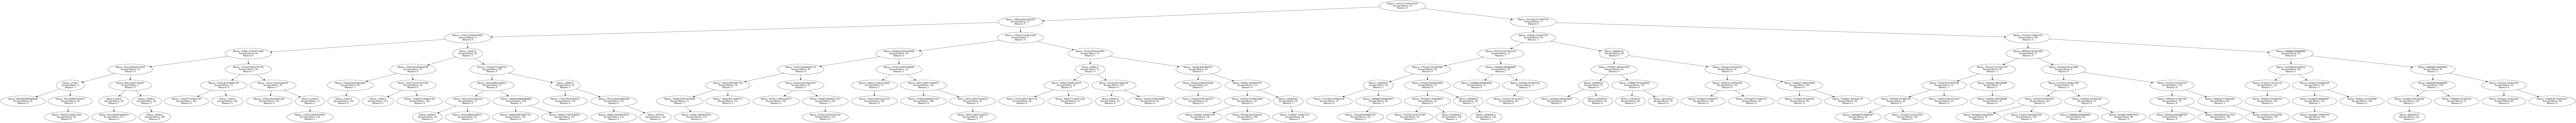

In [17]:
if operation == "Delete ":
    node_tree = avl_tree.execute_query(f"SELECT * WHERE {node_query}")
    if isinstance(node_tree, list):
        to_delete = node_tree[0]
        avl_tree.delete(to_delete.data['metric'])
    else:
        avl_tree.delete(node_tree.data['metric'])
else:
   found_nodes = avl_tree.execute_query(f"SELECT * WHERE {node_query}")
   found_node_str = [element.data['title'] for element in found_nodes]
   print(found_nodes)

dot = avl_tree.to_dot()  

src = Source(dot.source, format="png")


png_bytes = src.pipe(format="png")
with open("tree.png", "wb") as f:
    f.write(png_bytes)


display(Image("tree.png"))

### Operations with found nodes

**Subsequently, you found certain nodes using metrics, now select one of your found nodes,**

In [28]:
selected_node = 'Apartamento En Arriendo/venta En Barranquilla Ciudad Jardin Cod. AARE67336'

In [31]:
index = found_node_str.index(selected_node)
op_node = found_nodes[index]


found_node , parent_node = avl_tree.search(op_node.data['metric'])
grandfather_node = avl_tree.search_grandfather(op_node.data['metric'])
uncle_node = avl_tree.search_uncle(op_node.data['metric'])

# Verifica si se encontró el nodo
if found_node:

    # Accede a los datos asociados al nodo
    data = found_node.data
    
    # Define un formato personalizado para mostrar los datos
    popup_content = f"""
    <b>{found_node.data["title"]}</b><br>
    Metric: {found_node.data['metric']}<br>
    Level : {avl_tree.get_node_level(found_node.data['metric'])}<br>
    Balance: {-1 * avl_tree.get_balance(found_node)}
    <br>Department: {found_node.data["department"]}<br>
    City: {found_node.data["city"]}<br>
    Price: {found_node.data["price"]}<br>
    Total Area: {found_node.data["surface_total"]}<br>
    Covered Area: {found_node.data["surface_covered"]}<br>
    Bedrooms: {found_node.data["bedrooms"]}<br>
    Bathrooms: {found_node.data["bathrooms"]}<br>
    Operation Type: {found_node.data["operation_type"]}<br>
    """

    popup = folium.Popup(popup_content, max_width=300)

    # Extrae la latitud y longitud del diccionario de datos del nodo encontrado
    latitude = data["latitude"]
    longitude = data["longitude"]


    if latitude is not None and longitude is not None:
        mapa = folium.Map(location=[latitude, longitude], zoom_start=15)

        # Agrega un marcador para el nodo encontrado con un popup y un tooltip
        folium.Marker(
            [latitude, longitude],
            tooltip='Nodo encontrado',
            icon=folium.Icon(color='blue'),
            popup=popup  # Agrega un popup con la información completa
        ).add_to(mapa)

        # Extrae la latitud y longitud del diccionario de datos del nodo padre
        if parent_node:
            parent_latitude = parent_node.data["latitude"]
            parent_longitude = parent_node.data["longitude"]
        

            # Define un formato personalizado para mostrar los datos del nodo padre
            popup_content = f"""
            <b>{parent_node.data["title"]}</b><br>
            Metric: {parent_node.data['metric']}
            Balance: {-1 * avl_tree.get_balance(parent_node)}<br>
            Level : {avl_tree.get_node_level(parent_node.data['metric'])}<br>
            <br>Department: {parent_node.data["department"]}<br>
            City: {parent_node.data["city"]}<br>
            Price: {parent_node.data["price"]}<br>
            Total Area: {parent_node.data["surface_total"]}<br>
            Covered Area: {parent_node.data["surface_covered"]}<br>
            Bedrooms: {parent_node.data["bedrooms"]}<br>
            Bathrooms: {parent_node.data["bathrooms"]}<br>
            Operation Type: {parent_node.data["operation_type"]}<br>
             """


            # Crear un popup con el contenido formateado
            popup = folium.Popup(popup_content, max_width=300)

            # Agrega un marcador para el nodo padre con un popup y un tooltip
            folium.Marker(
                [parent_latitude, parent_longitude],
                tooltip='Padre del nodo encontrado',
                icon=folium.Icon(color='green'),
                popup=popup  # Agrega un popup con la información del nodo padre
            ).add_to(mapa)

            # Agrega el abuelo al mapa si existe
        if grandfather_node:
            grandfather_latitude = grandfather_node.data["latitude"]
            grandfather_longitude = grandfather_node.data["longitude"]
        

            # Define un formato personalizado para mostrar los datos del abuelo
            popup_content = f"""
            <b>{grandfather_node.data["title"]}</b><br>
            Metric: {grandfather_node.data['metric']}<br>
            Balance: {-1 * avl_tree.get_balance(grandfather_node)}<br>
            Level : {avl_tree.get_node_level(grandfather_node.data['metric'])}
            <br>Department: {grandfather_node.data["department"]}<br>
            City: {grandfather_node.data["city"]}<br>
            Price: {grandfather_node.data["price"]}<br>
            Total Area: {grandfather_node.data["surface_total"]}<br>
            Covered Area: {grandfather_node.data["surface_covered"]}<br>
            Bedrooms: {grandfather_node.data["bedrooms"]}<br>
            Bathrooms: {grandfather_node.data["bathrooms"]}<br>
            Operation Type: {grandfather_node.data["operation_type"]}<br>
            """


            # Crear un popup con el contenido formateado
            popup = folium.Popup(popup_content, max_width=300)

            # Agrega un marcador para el abuelo con un popup y un tooltip
            folium.Marker(
                [grandfather_latitude, grandfather_longitude],
                tooltip='Abuelo del nodo encontrado',
                icon=folium.Icon(color='orange'),  # Cambia el color del icono
                popup=popup  # Agrega un popup con la información del abuelo
            ).add_to(mapa)

        # Agrega al tío al mapa si existe
        if uncle_node:
            uncle_latitude = uncle_node.data["latitude"]
            uncle_longitude = uncle_node.data["longitude"]
        

            # Define un formato personalizado para mostrar los datos del tío
            popup_content = f"""
            <b>{uncle_node.data["title"]}</b><br>
            Metric: {uncle_node.data['metric']}<br>
            Balance: {-1 * avl_tree.get_balance(uncle_node)}<br>
            Level : {avl_tree.get_node_level(uncle_node.data['metric'])}
            <br>Department: {uncle_node.data["department"]}<br>
            City: {uncle_node.data["city"]}<br>
            Price: {uncle_node.data["price"]}<br>
            Total Area: {uncle_node.data["surface_total"]}<br>
            Covered Area: {uncle_node.data["surface_covered"]}<br>
            Bedrooms: {uncle_node.data["bedrooms"]}<br>
            Bathrooms: {uncle_node.data["bathrooms"]}<br>
            Operation Type: {uncle_node.data["operation_type"]}<br>
            """


            # Crear un popup con el contenido formateado
            popup = folium.Popup(popup_content, max_width=300)

            # Agrega un marcador para el tío con un popup y un tooltip
            folium.Marker(
                [uncle_latitude, uncle_longitude],
                tooltip='Tío del nodo encontrado',
                icon=folium.Icon(color='red'),  # Cambia el color del icono
                popup=popup  # Agrega un popup con la información del tío
            ).add_to(mapa)

        # Muestra el mapa en la celda de Colab
        display(mapa)
    else:
        print("El nodo encontrado no tiene información de latitud y longitud.")
else:
    print("No se encontró el nodo con métrica", value_to_search, "en el árbol.")


10.992
-74.817
6.239
-75.608
10.992
-74.817
7.116
-73.114


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=80ff16d9-42c2-4f44-9735-18cfd5dbbfbf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>